In [252]:
import pandas as pd
import folium
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
import os
from scipy.interpolate import griddata
import numpy as np
from IPython.display import display, IFrame
#print(os.getcwd())
import ipywidgets as widgets
file_path = "data_19.txt"

In [278]:
df_raw = pd.read_csv(file_path)#, lineterminator='\n')
df=df_raw[df_raw[" Latitude"] != 0]
df=df[df[" Longitude"] != 0] 
#print(df)
choix=widgets.RadioButtons(
    options=df.columns[1:6].tolist(),
    value=' eCO2 (ppm)', 
#    layout={'width': 'max-content'}, # If the items' names are long
    description='Choix du capteur à cartographier :',
    disabled=False
)

# save fichier clean
df.to_csv(file_path.split(".")[0]+"_traites.csv", index=False)
display(choix)

scaling=widgets.IntSlider(
    value=14,
    min=5,
    max=20,
    step=1,
    description='scale:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
display(scaling)

from IPython.display import display
button = widgets.Button(description="Calcul carte")
output = widgets.Output()

display(button, output)
heatmap = []
Capteur = ""
def on_button_clicked(b):
    
    global heatmap
    global Capteur
    with output:
        print("Carte calculée"+" pour "+choix.value)
        colonnes = [" Latitude", " Longitude", choix.value] 
        heatmap = df[colonnes].values.tolist()
        Capteur = choix.value

        m=folium.Map(
        [df[" Latitude"].iloc[0], df[" Longitude"].iloc[0]],
        control_scale=True,
        zoom_start=scaling.value,
        )

        HeatMap(heatmap).add_to(m)
        
        m.save(file_path.split(".")[0]+"_map_"+choix.value+".html")
        display(m)
        display(IFrame(file_path.split(".")[0]+"_map_"+choix.value+".html", width=600, height=400))
        
        m2 = folium.Map(
        location=[df[" Latitude"].iloc[0], df[" Longitude"].iloc[0]],
        control_scale=True,
        zoom_start=scaling.value
        )

        for _, row in df.iterrows():
            folium.CircleMarker(
                location=[row[" Latitude"], row[" Longitude"]],
                radius=1,               # Taille du marqueur
                color="black",          # Couleur du contour
                weight=2,               # Épaisseur du contour
                fill=False,             # Pas de remplissage pour simuler une croix
                #tooltip=f"Valeur : {row[' valeur']}"
            ).add_to(m2)
            
        m2.save(file_path.split(".")[0]+"_map_mesures.html")
        display(m2)
        display(IFrame(file_path.split(".")[0]+"_map_mesures.html", width=600, height=400))
        
        
                
button.on_click(on_button_clicked)

RadioButtons(description='Choix du capteur à cartographier :', index=4, options=(' Température (°C)', ' Humidi…

IntSlider(value=14, continuous_update=False, description='scale:', max=20, min=5)

Button(description='Calcul carte', style=ButtonStyle())

Output()

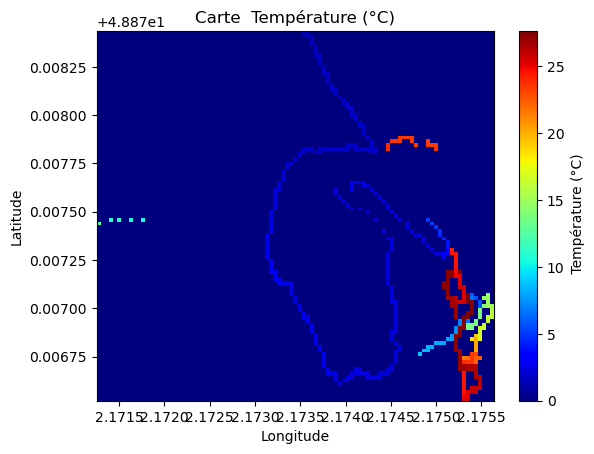

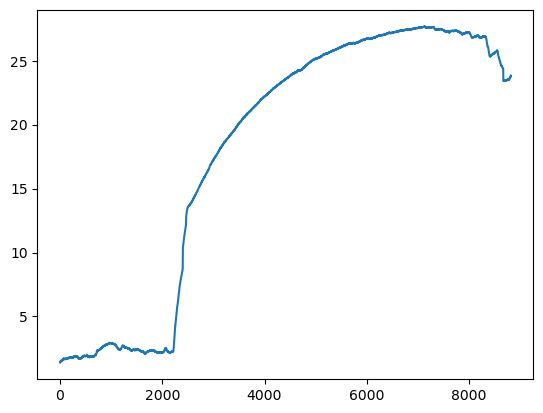

In [279]:
heatShow = np.array(heatmap)

# Extraire les latitudes, longitudes et valeurs
latitudes = heatShow[:, 0]
longitudes = heatShow[:, 1]
values = heatShow[:, 2]

# Définir les limites de la grille
lat_min, lat_max = min(latitudes), max(latitudes)
lon_min, lon_max = min(longitudes), max(longitudes)

# Créer des indices pour la grille
lat_bins = np.linspace(lat_min, lat_max, 100)  # 100 points pour latitude
lon_bins = np.linspace(lon_min, lon_max, 100)  # 100 points pour longitude

# Créer une grille 2D pour stocker les valeurs
grid = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))

# Remplir la grille avec les valeurs
for i in range(len(heatShow)):
    lat_idx = np.digitize(latitudes[i], lat_bins) - 1  # Trouver l'index pour la latitude
    lon_idx = np.digitize(longitudes[i], lon_bins) - 1  # Trouver l'index pour la longitude

    # Limiter les indices pour éviter l'index out of bounds
    lat_idx = min(lat_idx, len(lat_bins) - 2)
    lon_idx = min(lon_idx, len(lon_bins) - 2)

    grid[lat_idx, lon_idx] = values[i]  # Placer la valeur dans la grille

# Afficher la carte de chaleur avec imshow
plt.imshow(grid, extent=[lon_min, lon_max, lat_min, lat_max], origin='lower', aspect='auto',cmap="jet")
#plt.imshow(grid, extent=[lon_min, lon_max, lat_min, lat_max], origin='lower',cmap="jet")
plt.colorbar(label=Capteur)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Carte "+Capteur)
plt.show()
plt.plot(values)


In [196]:
#print(heatShow)
print(heatShow[1, 0])
print(lat_idx )
print(Capteur)
#plt.plot(df)
from IPython.display import IFrame



48.844181
94
 TVOC (ppb)


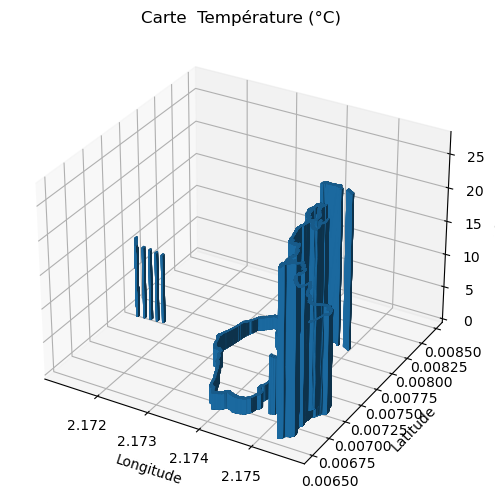

In [280]:
dx = dy = 0.00003 
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(heatShow[:, 1], heatShow[:, 0], np.zeros_like(heatShow[:, 2]), dx, dy, heatShow[:, 2], shade=True, cmap='jet')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Valeur")
ax.set_title("Carte "+Capteur)
plt.show()

In [305]:
import pydeck as pdk
import pandas as pd

# Exemple de données (latitude, longitude, hauteur)
data = pd.DataFrame({
    'lat': heatShow[:, 0],  # Latitude
    'lon': heatShow[:, 1],      # Longitude
    'elevation': heatShow[:, 2]    # Hauteur (valeurs pour les bâtons)
})
 
# Créer la carte avec des bâtons verticaux (Colonnes extrudées)
deck_map = pdk.Deck(
    
    layers=[
        pdk.Layer(
            'HexagonLayer',  # Type de couche pour des colonnes (bâtons verticaux)
            data=data,
            get_position='[lon, lat]',  # Position des bâtons (longitude, latitude)
            get_elevation='elevation',  # Hauteur des bâtons
            radius=1,  # Rayon de la base du bâton
            elevation_scale=10,  # Échelle des hauteurs
            pickable=True,
            extruded=True,  # Extrusion pour créer des bâtons 3D
            opacity=0.5,
            #color=[255, 0, 0]  # Couleur des bâtons (rouge dans cet exemple)
            auto_highlight=True,
    
    elevation_range=[0, 500],
    
    #coverage=1,
        )
    ],
    
    initial_view_state=pdk.ViewState(
        heatShow[0, 1],
        heatShow[0, 0],
        zoom=14,
        pitch=45,  # Inclinaison de la carte pour mieux voir l'effet 3D
        bearing=0,
        #map_style='light',  # Utiliser un fond clair
    #light_settings={
        #'lightPosition': [100, 100, 1000],  # Position de la source lumineuse
      #  'ambientRatio': 0.8,  # Intensité de la lumière ambiante, augmenter pour éclaircir
      #  'diffuseRatio': 0.5,  # Intensité de la lumière diffuse
     #   'specularRatio': 0.2,  # Intensité de la lumière spéculaire
     #   'spotLightColor': [255, 255, 255],  # Couleur de la lumière du spot
   # }
    )

)


#deck_map.show()

deck_map.to_html(file_path.split(".")[0]+"_3D_map_"+choix.value+".html")

#